In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_coordinates (image, params):
     
    slope, intercept = params 
    y1 = image.shape[0]     
    y2 = int(y1 * (3/5)) # Setting y2 at 3/5th from y1
    x1 = int((y1 - intercept) / slope) # Deriving from y = mx + c
    x2 = int((y2 - intercept) / slope) 
    
    return np.array([x1, y1, x2, y2])

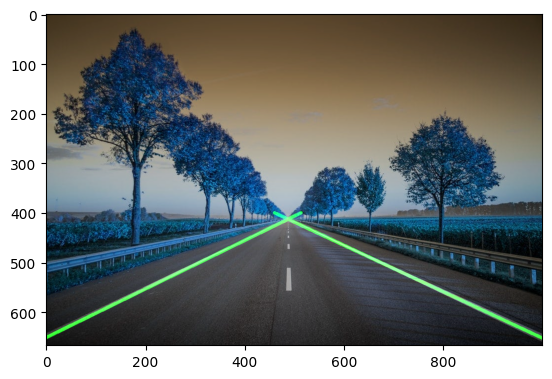

In [7]:
rgb_image = cv2.imread('image.jpg')

plt.imshow(rgb_image)

height = rgb_image.shape[0]
width = rgb_image.shape[1]

#Converting to grey scale, blurring the image, and applying canny edge detection
grey_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(grey_image, (5,5), 1.4)
edges = cv2.Canny(blurred_image, 50, 150)

#Finding ROI
#A triange needs to be created for shaping the area of interest 
triangle_coord = np.array([ 
        [(0, height), (round(width/2), round(height/2)), (1000, height)] 
        ]) 
    
black_mask = np.zeros_like(grey_image) 
mask_plus_polygon = cv2.fillPoly(black_mask, triangle_coord, 255)  ## 255 is the mask color
cropped_image = cv2.bitwise_and(edges, mask_plus_polygon)

#finding lanes using Hough transformation
lines = cv2.HoughLinesP(
    cropped_image,
    rho=1.3,              #Distance resolution in pixels
    theta=np.pi / 90,   #Angle resolution in radians
    threshold=150,      #Min. number of intersecting points to detect a line  
    lines=np.array([]), #Vector to return start and end points of the lines indicated by [x1, y1, x2, y2] 
    minLineLength=50,   #Line segments shorter than this are rejected
    maxLineGap=25       #Max gap allowed between points on the same line
)

#Processing lanes data and find average lanes
left = [] 
right = [] 

for line in lines: 
    x1, y1, x2, y2 = line.reshape(4)
        
    # Fit polynomial, find intercept and slope 
    params = np.polyfit((x1, x2), (y1, y2), 1)  
    slope = params[0] 
    y_intercept = params[1] 
    
    if slope < 0: 
        left.append((slope, y_intercept)) #Negative slope = left lane
    else: 
        right.append((slope, y_intercept)) #Positive slope = right lane

left_avg = np.average(left, axis = 0) 
right_avg = np.average(right, axis = 0) 

left_line = get_coordinates(cropped_image, left_avg) 
right_line = get_coordinates(cropped_image, right_avg)

averaged_lines = [left_line, right_line]


#plotting average lanes data on line image(a black image)
line_image = np.zeros_like(rgb_image)
for item in averaged_lines:
    x1,y1,x2,y2 = item
    color = [0,255,0]
    thickness = 5
    cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)

#combining line image and original image
combined_image = cv2.addWeighted(rgb_image, 0.8, line_image, 1, 0)

plt.imshow(combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()